In [5]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display


In [6]:
DATA_DIR = r"Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data"

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}

In [7]:
# Load datasets
import os

df_heart = pd.read_csv(os.path.join(DATA_DIR, DATASETS["heart_diagnoses_1"]))
df_labs = pd.read_csv(os.path.join(DATA_DIR, DATASETS["laboratory_events_codes_2"]))
df_micro = pd.read_csv(os.path.join(DATA_DIR, DATASETS["microbiology_events_codes_3"]))
df_procedure = pd.read_csv(os.path.join(DATA_DIR, DATASETS["procedure_code_4"]))

In [21]:
summary = pd.DataFrame({
    "Dataset": ["Heart Diagnoses", "Labs", "Microbiology", "Procedures"],
    "Rows": [len(df_heart), len(df_labs), len(df_micro), len(df_procedure)],
    "Columns": [len(df_heart.columns), len(df_labs.columns), len(df_micro.columns), len(df_procedure.columns)],
    "Keys": ["subject_id, hadm_id", "hadm_id", "subject_id, hadm_id", "subject_id, hadm_id"],
    "Content": [
        "ICD diagnoses",
        "Laboratory test results",
        "Microbiology tests",
        "Procedure codes"
    ]
})
summary

,Dataset,Rows,Columns,Keys,Content
0,Heart Diagnoses,4864,25,"subject_id, hadm_id",ICD diagnoses
1,Labs,978503,14,hadm_id,Laboratory test results
2,Microbiology,15587,14,"subject_id, hadm_id",Microbiology tests
3,Procedures,14497,6,"subject_id, hadm_id",Procedure codes


In [ ]:
def numeric_summary(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=["number"]).columns.tolist()
        cols = [c for c in cols if c not in ('subject_id', 'hadm_id')]
    out = []
    for c in cols:
        s = df[c]
        out.append({
            "variable": c,
            "min": s.min(),
            "max": s.max(),
            "mean": s.mean(),
            "std": s.std(),
            "missing_%": s.isna().mean() * 100
        })
    return pd.DataFrame(out)

num_stats = pd.concat(
    [
        numeric_summary(df_heart),
        numeric_summary(df_labs),
        numeric_summary(df_micro),
        numeric_summary(df_procedure)
    ],
    ignore_index=True
)

num_stats

,variable,min,max,mean,std,missing_%
0,subject_id,10000980.00,19998600.0,1.510717e+07,2.938761e+06,0.000000
1,hadm_id,20004456.00,29999670.0,2.501745e+07,2.873736e+06,0.000000
2,note_seq,2.00,94.0,1.469100e+01,8.260520e+00,0.000000
3,subject_id_dx,10000980.00,19998497.0,1.500158e+07,2.879841e+06,0.000000
4,age,18.00,95.0,6.897872e+01,1.497336e+01,71.977796
5,anchor_year,2110.00,2206.0,2.155621e+03,2.340010e+01,71.977796
6,hadm_id,20004456.00,29999670.0,2.504395e+07,2.868159e+06,0.000000
7,valuenum,-743.00,886449.0,6.733232e+01,2.175589e+03,7.274990
8,ref_range_lower,0.00,2200.0,3.172462e+01,4.484084e+01,11.544063
9,ref_range_upper,0.00,100000.0,5.579486e+01,4.005150e+02,11.544063


In [11]:
def quality_summary(df, name):
    return {
        "dataset": name,
        "missing_%": df.isna().mean().mean() * 100,
        "duplicates": df.duplicated().sum()
    }

dq = pd.DataFrame([
    quality_summary(df_heart, "Heart Diagnoses"),
    quality_summary(df_labs, "Labs"),
    quality_summary(df_micro, "Microbiology"),
    quality_summary(df_procedure, "Procedures")
])
dq

,dataset,missing_%,duplicates
0,Heart Diagnoses,12.329770,0
1,Labs,13.888592,2
2,Microbiology,29.491609,1
3,Procedures,0.000000,0


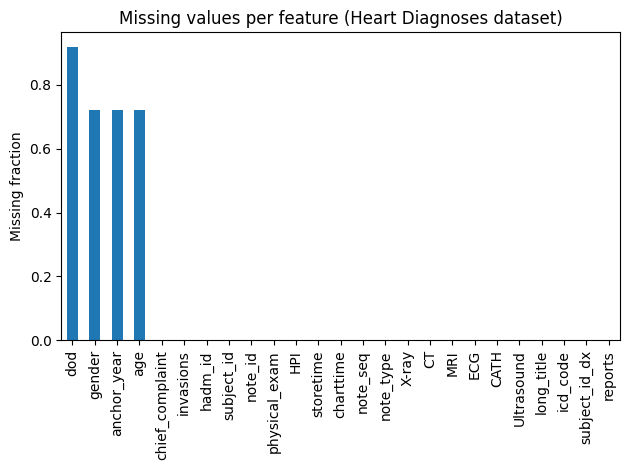

In [12]:
miss = df_heart.isna().mean().sort_values(ascending=False)

plt.figure()
miss.plot(kind="bar")
plt.ylabel("Missing fraction")
plt.title("Missing values per feature (Heart Diagnoses dataset)")
plt.tight_layout()
plt.show()


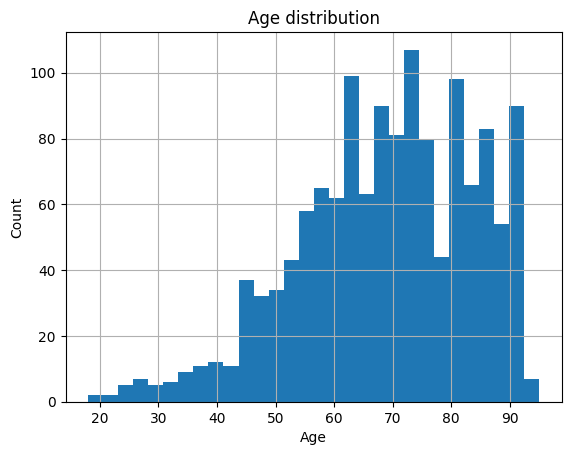

In [13]:
plt.figure()
df_heart["age"].dropna().hist(bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution")
plt.show()


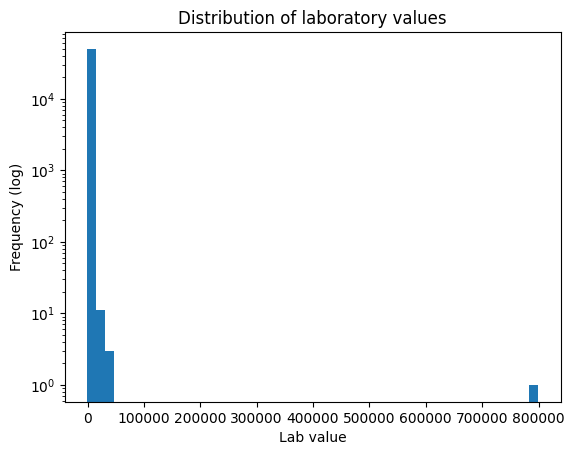

In [14]:
sample = df_labs["valuenum"].dropna().sample(50000, random_state=42)

plt.figure()
plt.hist(sample, bins=50)
plt.yscale("log")
plt.xlabel("Lab value")
plt.ylabel("Frequency (log)")
plt.title("Distribution of laboratory values")
plt.show()


In [15]:
labs_agg = (
    df_labs
    .groupby("hadm_id")["valuenum"]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
)

adm = df_heart[["hadm_id", "age"]].drop_duplicates()
corr_df = adm.merge(labs_agg, on="hadm_id")


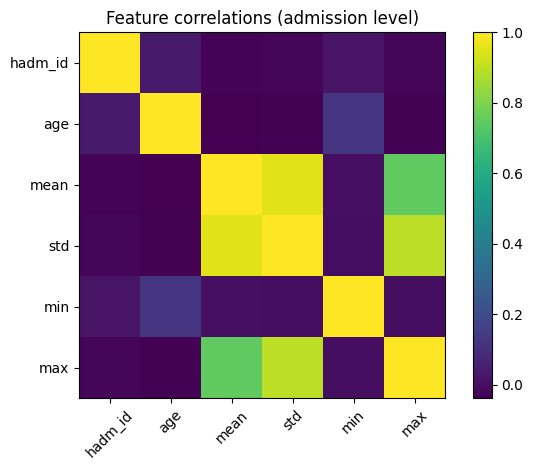

In [16]:
corr = corr_df.corr()

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature correlations (admission level)")
plt.tight_layout()
plt.show()
